# Entrenamiento con regresión logística


In [306]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 #pip install opencv-python
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from scipy.optimize import minimize
import librosa                    
import librosa.display
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew

In [307]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            genres[genre] = i
            i+=1
print(genres)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### Usando el código de las prácticas

In [308]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

In [309]:
def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img.ravel()
    return np.array(x)

In [310]:
X = get_x()
y = get_y()
y = y.reshape(len(y),1)
X.shape

(999, 72695)

In [311]:
print(X.shape, y.shape)

(999, 72695) (999, 1)


In [312]:
y = y.T[0]
num_examples = np.shape(X)[0] #999 imagenes
num_features = np.shape(X)[1] #72695 atributos por cada imagen
num_etiquetas = 10 # hay 10 generos

# añadimos una columna de 1's a la X
X = np.hstack([np.ones([num_examples, 1]), X])
X

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72696) (749, 72696) (250, 72696)


In [313]:
#funciones sigmoide, coste y gradiente de regresion logistica
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(Theta, X, Y, Lambda):
    epsilon = 1e-5   #para evitar errores del tipo "RuntimeWarning: divide by zero encountered in log import sys" le sumamos un epsilon cercano a cero para que nunca calcule el log de (0)
    H = sigmoid(np.matmul(X, Theta))
    aux = (-1 / len(X)) * ( np.matmul(np.log(H+epsilon).T, Y) + np.matmul(np.log(1-H+epsilon).T, (1-Y)))
    regul = (Lambda/(2*len(X))) * np.sum(Theta**2)
    return (aux + regul)

def gradient(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = np.matmul(X.T, H - Y) / len(X)
    regul = (Lambda/len(X)) * Theta
    return (aux + regul)

In [314]:
import scipy.optimize as opt
def oneVsAll(X, y, num_etiquetas, reg):
    """
    oneVsAll entrena varios clasificadores por regresión logística con término
    de regularización 'reg' y devuelve el resultado en una matriz, donde la 
    fila i-ésima corresponde al clasificador de la etiqueta i-ésima
    """
    # Creamos una matriz de 'num_etiquetas' clasificadores con 'num_features + 1' atributos cada uno
    classifiers = np.zeros(shape=(num_etiquetas, num_features + 1))
    
    # entrenamos un clasificador por cada una de las clases del conjunto de datos
    for i in range(num_etiquetas):
        # Necesitamos un valor de theta por cada atributo
        theta = np.zeros(num_features + 1)
        
        # Dividimos nuestras clases en dos conjuntos, la clase que queremos predecir (y == i) y el resto (y != i)
        if i == 0:
            label = (y == 0) * 1
        else:
            label = (y == i) * 1

        # Entrenamos al clasificador
        result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, label, reg))
        classifiers[i, :] = result[0]
        
    return classifiers

In [315]:
regul_param = 0.1
classifiers = oneVsAll(X_train, y_train, num_etiquetas, regul_param)

In [316]:
probabilities = sigmoid(np.matmul(X_test, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)

In [317]:
print("Numero de test: ", len(y_test))
fallos =  np.where([predictions != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 138
Numero de aciertos: 112
Porcentaje de aciertos:  44.800000000000004


In [264]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k

In [265]:
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[predictions[a]],"::" ,genres_pred[y_test[a]])

blues :: reggae
blues :: classical
reggae :: hiphop
country :: reggae
metal :: hiphop
disco :: rock
metal :: hiphop
jazz :: hiphop
pop :: disco
metal :: rock


In [266]:
predictions

array([5, 1, 6, 8, 7, 5, 6, 1, 6, 5, 3, 9, 4, 2, 6, 1, 6, 6, 6, 7, 8, 5,
       6, 0, 7, 2, 3, 7, 3, 8, 3, 1, 4, 6, 6, 1, 8, 6, 0, 1, 2, 6, 6, 1,
       1, 5, 1, 9, 0, 6, 3, 6, 6, 6, 1, 9, 5, 7, 3, 8, 0, 5, 4, 5, 0, 6,
       8, 7, 4, 5, 6, 6, 4, 3, 6, 0, 9, 0, 2, 3, 8, 6, 3, 7, 9, 4, 1, 1,
       7, 6, 4, 6, 1, 9, 8, 4, 2, 2, 6, 6, 1, 8, 6, 6, 2, 6, 7, 6, 8, 1,
       7, 4, 8, 0, 7, 0, 1, 4, 5, 9, 9, 5, 1, 0, 6, 6, 5, 6, 1, 0, 5, 5,
       5, 4, 7, 9, 5, 2, 9, 7, 1, 5, 7, 6, 6, 5, 9, 9, 1, 0, 6, 5, 6, 8,
       5, 6, 0, 4, 0, 3, 8, 3, 0, 5, 7, 8, 3, 6, 4, 2, 0, 3, 7, 4, 6, 7,
       4, 9, 6, 8, 2, 9, 3, 5, 6, 3, 1, 2, 7, 8, 1, 0, 0, 4, 6, 9, 6, 6,
       1, 5, 3, 2, 4, 0, 6, 8, 6, 6, 7, 2, 8, 2, 6, 5, 6, 8, 0, 7, 7, 7,
       0, 7, 0, 8, 0, 5, 6, 6, 0, 6, 5, 5, 4, 8, 6, 6, 0, 2, 1, 1, 6, 4,
       6, 8, 5, 6, 2, 9, 9, 7], dtype=int64)

In [267]:
cm = confusion_matrix(y_test, predictions)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

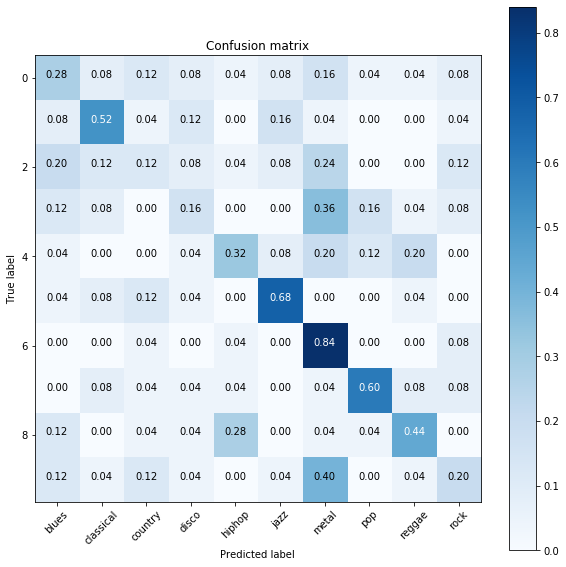

In [268]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    #plt.yticks(tick_marks, genres)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [269]:
files = os.listdir('./test_songs/images/')
songs = [ img for img in files if img.split('.')[-1] == 'png']
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

### Canciones fuera del dataset

In [270]:
files = os.listdir('./test_songs/images/')
# songs = [ img for img in files if img.split('.')[-1] == 'png']
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']

for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    mel = np.hstack([1, mel])
#     pred = logreg2.predict(mel.reshape(1, -1))
    probabilities = sigmoid(np.matmul(mel.reshape(1,-1), classifiers.T))
    # Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
    pred = np.argmax(probabilities, axis=1)
    print(song)
    print(genres_pred[int(pred)])

./test_songs/images/abba.png
rock
./test_songs/images/desakato.png
metal
./test_songs/images/elfinde.png
hiphop
./test_songs/images/harder.png
disco
./test_songs/images/iseo.png
pop
./test_songs/images/marley.png
pop
./test_songs/images/metallica.png
metal
./test_songs/images/paradise.png
hiphop
./test_songs/images/requiem.png
classical
./test_songs/images/sultans.png
blues
./test_songs/images/wutang.png
country


## Sklearn

In [271]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.feature_selection import SelectFromModel
# import lightgbm as lgbm
# from sklearn.linear_model import LogisticRegression

# params = {
#     "cls__penalty": ["l1", "l2"],
#     "cls__C": [0.5, 1, 2, 5],
#     "cls__max_iter": [500]
# }

# pipe_lr = Pipeline([
#     ('scale', StandardScaler()),
#     ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
#     ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
#     ('cls', LogisticRegression())
# ])

# grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
# grid_lr.fit(X_train, y_train)

In [272]:
# preds = grid_lr.predict(X_test)
# print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
# print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

In [273]:
from sklearn.linear_model import LogisticRegression
logreg2=LogisticRegression(C=0.001,penalty="l2",max_iter=10000,multi_class = "multinomial", solver = "lbfgs")
logreg2.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [274]:
preds = logreg2.predict(X_test)
preds

array([5, 1, 6, 8, 7, 5, 6, 1, 2, 5, 0, 9, 4, 2, 6, 4, 2, 0, 6, 7, 8, 5,
       6, 0, 7, 0, 3, 7, 3, 8, 3, 1, 0, 0, 9, 1, 7, 9, 0, 5, 7, 9, 6, 1,
       1, 5, 2, 9, 0, 6, 3, 4, 6, 6, 1, 9, 5, 7, 7, 8, 0, 5, 4, 5, 0, 6,
       8, 7, 4, 5, 4, 6, 4, 3, 3, 2, 9, 0, 2, 3, 8, 9, 3, 7, 9, 4, 1, 1,
       7, 6, 4, 6, 1, 9, 8, 4, 2, 5, 6, 4, 1, 5, 4, 4, 2, 6, 7, 0, 4, 1,
       7, 4, 8, 0, 7, 9, 1, 4, 5, 9, 3, 5, 1, 0, 6, 6, 5, 4, 1, 0, 5, 5,
       5, 4, 7, 1, 5, 2, 9, 7, 1, 5, 7, 6, 6, 1, 9, 9, 1, 0, 6, 3, 6, 8,
       1, 6, 0, 4, 4, 3, 8, 3, 8, 5, 7, 8, 3, 7, 4, 2, 0, 3, 7, 4, 8, 1,
       4, 9, 6, 8, 0, 9, 8, 5, 8, 3, 2, 2, 7, 4, 1, 0, 8, 4, 6, 7, 0, 9,
       3, 5, 3, 2, 4, 9, 4, 8, 4, 6, 7, 5, 9, 2, 7, 5, 6, 8, 0, 7, 7, 1,
       0, 7, 0, 8, 8, 8, 6, 6, 0, 6, 5, 5, 4, 8, 4, 6, 0, 2, 1, 5, 9, 4,
       8, 4, 5, 3, 2, 9, 9, 7])

In [275]:
print("Numero de test: ", len(y_test))
fallos =  np.where([preds != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([preds == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(preds == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 124
Numero de aciertos: 126
Porcentaje de aciertos:  50.4


In [276]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
print("Muestreo de fallos\n")
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[preds[a]],"::" ,genres_pred[y_test[a]])

Muestreo de fallos

jazz :: rock
jazz :: classical
pop :: disco
blues :: hiphop
metal :: pop
pop :: rock
jazz :: country
pop :: disco
disco :: classical
hiphop :: metal


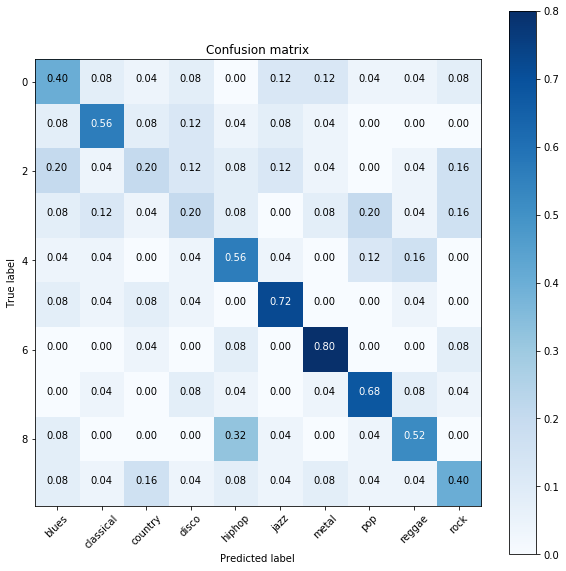

In [277]:
cm2 = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2, classes, normalize=True)

### Canciones fuera del dataset usando sklearn

In [278]:
files = os.listdir('./test_songs/images/')
# songs = [ img for img in files if img.split('.')[-1] == 'png']
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']
songs

['./test_songs/images/abba.png',
 './test_songs/images/desakato.png',
 './test_songs/images/elfinde.png',
 './test_songs/images/harder.png',
 './test_songs/images/iseo.png',
 './test_songs/images/marley.png',
 './test_songs/images/metallica.png',
 './test_songs/images/paradise.png',
 './test_songs/images/requiem.png',
 './test_songs/images/sultans.png',
 './test_songs/images/wutang.png']

In [279]:
for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    mel = np.hstack([1, mel])
    pred = logreg2.predict(mel.reshape(1, -1))
    print(song, "-->" ,genres_pred[int(pred)])

./test_songs/images/abba.png --> rock
./test_songs/images/desakato.png --> pop
./test_songs/images/elfinde.png --> pop
./test_songs/images/harder.png --> hiphop
./test_songs/images/iseo.png --> hiphop
./test_songs/images/marley.png --> pop
./test_songs/images/metallica.png --> metal
./test_songs/images/paradise.png --> hiphop
./test_songs/images/requiem.png --> classical
./test_songs/images/sultans.png --> country
./test_songs/images/wutang.png --> hiphop


### Usando features del csv

In [280]:
df = pd.read_csv('./data/features_30_sec.csv')

In [281]:
df.loc[df['filename'] == 'jazz.00054.wav'] #Corrupted

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
554,jazz.00054.wav,662112,0.27827,0.083737,0.162394,0.002747,1670.233117,255560.9662,2109.438546,191916.069574,...,44.333191,-5.273277,56.501907,-1.605975,60.76976,-2.93224,52.397224,-1.418922,100.980064,jazz


In [282]:
df1 = df.iloc[:, 1:-1]
features30sec = df1.to_numpy()
features30sec = np.delete(features30sec, 554, axis=0)

In [283]:
print(features30sec.shape) #Solo 58 features por cancion -> pocas

(999, 58)


In [284]:
# X_csv = df_features.drop(['genre'], axis=1).values
# y_csv = df_features['genre'].values

### mas features

In [285]:
#Funciones para obtener las caracteristicas de las canciones del dataset
#Obtenemos 133 caracteristicas, mas de el doble que de las que teniamos antes

def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                print(file)
                if(file != "jazz.00054.wav"): #archivo corrupto
                    file_name = folder + "/" + file
                    signal, sr = librosa.load(file_name)

                    # Debug process
                    if debug:
                        print("Reading file: {}".format(file_name))

                    # Append the result to the data structure
                    features = get_features(signal, sr)
                    features['genre'] = genres[x]
                    arr_features.append(features)
    return arr_features

In [286]:
%%time
# Get list of dicts with features and convert to dataframe
gtzan_dir = './data/genres_original/'
features = read_process_songs(gtzan_dir, debug=False) #10min aprox to execute
df_features = pd.DataFrame(features)

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav
blues.00010.wav
blues.00011.wav
blues.00012.wav
blues.00013.wav
blues.00014.wav
blues.00015.wav
blues.00016.wav
blues.00017.wav
blues.00018.wav
blues.00019.wav
blues.00020.wav
blues.00021.wav
blues.00022.wav
blues.00023.wav
blues.00024.wav
blues.00025.wav
blues.00026.wav
blues.00027.wav
blues.00028.wav
blues.00029.wav
blues.00030.wav
blues.00031.wav
blues.00032.wav
blues.00033.wav
blues.00034.wav
blues.00035.wav
blues.00036.wav
blues.00037.wav
blues.00038.wav
blues.00039.wav
blues.00040.wav
blues.00041.wav
blues.00042.wav
blues.00043.wav
blues.00044.wav
blues.00045.wav
blues.00046.wav
blues.00047.wav
blues.00048.wav
blues.00049.wav
blues.00050.wav
blues.00051.wav
blues.00052.wav
blues.00053.wav
blues.00054.wav
blues.00055.wav
blues.00056.wav
blues.00057.wav
blues.00058.wav
blues.00059.wav
blues.00060.wav
blues.00061.wav
blues.00

### Nuestra regresion logistica y datos del csv

In [287]:
X_csv = df_features.drop(['genre'], axis=1).values
y_csv = df_features['genre'].values

In [288]:
num_examples = np.shape(X_csv)[0] #999 imagenes
# num_features = np.shape(X_csv)[1] #133 atributos por cada cancion
X_csv = np.hstack([np.ones([num_examples, 1]), X_csv])

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X_csv, y_csv, stratify=y_csv)

In [290]:
X_csv.shape

(999, 134)

In [291]:
classifiers = oneVsAll(X_train, y_train, num_etiquetas, regul_param)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 72696 is different from 134)

In [ ]:
probabilities = sigmoid(np.matmul(X_test, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)

In [ ]:
print("Numero de test: ", len(y_test))
fallos =  np.where([predictions != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y_test)
print("Porcentaje de aciertos: ", accuracy)

In [ ]:
arr_features = []

# Read files from the folders
folder = './test_songs/'
files = os.listdir(folder)
files = ['./test_songs/'+img for img in files if img.split('.')[-1] == 'mp3']
for file in files:
    # Read the audio file
    signal, sr = librosa.load(file, duration=30.0)
    print("Reading file: {}".format(file))
    # Append the result to the data structure
    features = get_features(signal, sr)
    arr_features.append(features)

gtzan_dir = './test_songs'
df_features = pd.DataFrame(arr_features)

In [ ]:
X_pruebas = df_features
num_examples = np.shape(X_pruebas)[0]
num_features = np.shape(X_pruebas)[1] 
X_pruebas = np.hstack([np.ones([num_examples, 1]), X_pruebas])
X_pruebas.shape
num_features

In [ ]:
probabilities = sigmoid(np.matmul(X_pruebas, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)

In [ ]:
i = 0
for pred in predictions:
    print(songs[i][20:-4],"-->",genres_pred[int(pred)],'\n')
    i += 1

### Regresion logistica de sklearn y datos del csv

In [ ]:
X_csv = df_features.drop(['genre'], axis=1).values
y_csv = df_features['genre'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_csv, y_csv, stratify=y_csv)

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
logreg2=LogisticRegression(C=.001,penalty="l2",max_iter=10000,multi_class = "multinomial", solver = "lbfgs")
logreg2.fit(X_train,y_train)

In [ ]:
preds = logreg2.predict(X_test)

In [ ]:
print("Numero de test: ", len(y_test))
fallos =  np.where([preds != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([preds == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(preds == y_test)
print("Porcentaje de aciertos: ", accuracy)

In [ ]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
print("Muestreo de fallos\n")
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[preds[a]],"::" ,genres_pred[y_test[a]])

In [ ]:
cm2 = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2, classes, normalize=True)

In [ ]:
arr_features = []

# Read files from the folders
folder = './test_songs/'
files = os.listdir(folder)
files = ['./test_songs/'+img for img in files if img.split('.')[-1] == 'mp3']
for file in files:
    # Read the audio file
    signal, sr = librosa.load(file, duration=30.0)
    print("Reading file: {}".format(file))
    # Append the result to the data structure
    features = get_features(signal, sr)
    arr_features.append(features)

gtzan_dir = './test_songs'
df_features = pd.DataFrame(arr_features)

In [ ]:
X_pruebas = df_features
preds = logreg2.predict(X_pruebas)

In [ ]:
i = 0
for pred in preds:
    print(songs[i][20:-4],"-->",genres_pred[int(pred)],'\n')
    i += 1